In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow_datasets as tfds

In [ ]:
tf.config.experimental.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Bounding box utils

In [ ]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_box_on_image_array(image, boxes, color=[], thickness=1,
                               display_str_list=()):
    """Draws bounding boxes on image (numpy array).
    Args:
        image: a numpy array object.
        boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
            The coordinates are in normalized format between [0, 1].
        color: color to draw bounding box. Default is red.
        thickness: line thickness. Default value is 4.
        display_str_list_list: a list of strings for each bounding box.
    Raises:
        ValueError: if boxes is not a [N, 4] array
    """
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new('RGBA', image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes,color, thickness, display_str_list)
    return np.array(rgbimg)

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
    """Draws bounding boxes on image.
    Args:
        image: a PIL.Image object.
        boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
            The coordinates are in normalized format between [0, 1].
        color: color to draw bounding box. Default is red.
        thickness: line thickness. Default value is 4.
        display_str_list: a list of strings for each bounding box.
                            
    Raises:
        ValueError: if boxes is not a [N, 4] array
    """
    if  len(boxes.shape) != 2 or boxes.shape[1] != 4:
        raise ValueError('Input shape must be (N, 4)')
    for i in range (boxes.shape[0]):
        draw_bounding_box(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])
        
def draw_bounding_box(image, ymin, xmin, ymax, xmax, color='red', thickness=1, 
                      display_str=None, use_normalized_coordinates=True):
    
    """Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    Args:
        image: a PIL.Image object.
        ymin: ymin of bounding box.
        xmin: xmin of bounding box.
        ymax: ymax of bounding box.
        xmax: xmax of bounding box.
        color: color to draw bounding box. Default is red.
        thickness: line thickness. Default value is 4.
        display_str_list: string to display in box
        use_normalized_coordinates: If True (default), treat coordinates
        ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
        coordinates as absolute.
    """
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], 
              width=thickness, fill=color)


In [ ]:
#@title  { form-width: "100px", display-mode: "code" }
"""
This cell contains helper functions used for visualization
and downloads only. 

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""
iou_threshold = 0.6
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    
    # get one batch from each: 10000 validation digits, N training digits
    batch_train_ds = training_dataset.unbatch().batch(N)
    
    # eager execution: loop through datasets normally
    if tf.executing_eagerly():
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break
        for training_digits, (training_labels, training_bboxes) in batch_train_ds:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break
    
    # these were one-hot encoded in the dataset
    validation_labels = np.argmax(validation_labels, axis=1)
    training_labels = np.argmax(training_labels, axis=1)
    
    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
    font_labels = []
    img = PIL.Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
    d = PIL.ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i%10)
        d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
    font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
    font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
    return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

    n = 10

    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    if (len(pred_bboxes) > 0):
        n_pred_bboxes = pred_bboxes[indexes,:]

    if (len(bboxes) > 0):
        n_bboxes = bboxes[indexes,:]


    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n, 75, 75)
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    
    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])
        
        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_box_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])
        
        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color('red')

        
        
        plt.imshow(img_to_draw)

        if len(iou) > i :
            color = "black"
        if (n_iou[i][0] < iou_threshold):
            color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

# Selecting between strategies

In [ ]:
# detecting hardware
try:
    tf.distribute.cluster_resolver.TPUClusterResolver() # checks if tpu is available
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices('GPU')

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)

else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

# Loading and preprocessing dataset

In [ ]:
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0, 42, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 42, dtype=tf.int32)
    image = tf.reshape(image, (28, 28, 1))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32) / 255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)

    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin /= 75
    ymin /= 75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

def get_training_dataset():
    # boundingbox is found in the dataset
    with strategy.scope():
        dataset = tfds.load('mnist', split='train', as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(-1)
    return dataset

def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

In [ ]:
training_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 75, 75, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(64, 10), dtype=tf.float32, name=None), TensorSpec(shape=(64, 4), dtype=tf.float32, name=None)))>

In [ ]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

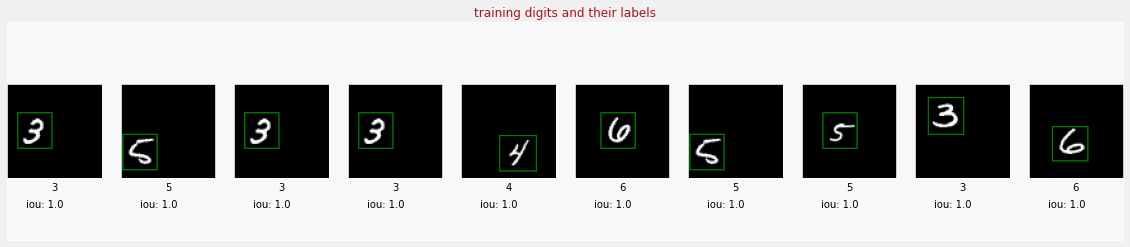

In [ ]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)
IOU = intersection_over_union(training_bboxes, training_bboxes)
display_digits_with_boxes(training_digits, training_labels, training_labels, training_bboxes, training_bboxes, IOU, "training digits and their labels")

# Creating Network

In [ ]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    return x

def base_model(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return tf.keras.layers.Dense(32, activation='relu')(x)

def output_layers(inputs):
    output1 = tf.keras.layers.Dense(units=4, activation='relu', name='bounding_box')(inputs)
    output2 = tf.keras.layers.Dense(10, activation='softmax', name='classification')(inputs)
    return output1, output2

def get_model():
    inputs = tf.keras.layers.Input(shape=(75, 75, 1))
    x = feature_extractor(inputs)
    x = base_model(x)
    output1, output2 = output_layers(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=[output2, output1])
    return model

with strategy.scope():
    model = get_model()

In [ ]:
model.compile(optimizer='adam', 
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })

In [ ]:
EPOCHS = 10 # 45
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
937/937 [==============================] - 36s 21ms/step - loss: 1.0083 - classification_loss: 0.9628 - bounding_box_loss: 0.0455 - classification_accuracy: 0.6602 - bounding_box_mse: 0.0455 - val_loss: 0.4258 - val_classification_loss: 0.3856 - val_bounding_box_loss: 0.0402 - val_classification_accuracy: 0.8768 - val_bounding_box_mse: 0.0402
Epoch 2/10
937/937 [==============================] - 11s 12ms/step - loss: 0.2836 - classification_loss: 0.2504 - bounding_box_loss: 0.0332 - classification_accuracy: 0.9238 - bounding_box_mse: 0.0332 - val_loss: 0.2243 - val_classification_loss: 0.1934 - val_bounding_box_loss: 0.0309 - val_classification_accuracy: 0.9432 - val_bounding_box_mse: 0.0309
Epoch 3/10
937/937 [==============================] - 11s 12ms/step - loss: 0.2083 - classification_loss: 0.1788 - bounding_box_loss: 0.0296 - classification_accuracy: 0.9470 - bounding_box_mse: 0.0296 - val_loss: 0.1507 - val_classification_loss: 0.1217 - val_bounding_box_loss: 0.0289 -

Number of predictions where iou > threshold(0.6): 2451
Number of predictions where iou < threshold(0.6): 7549


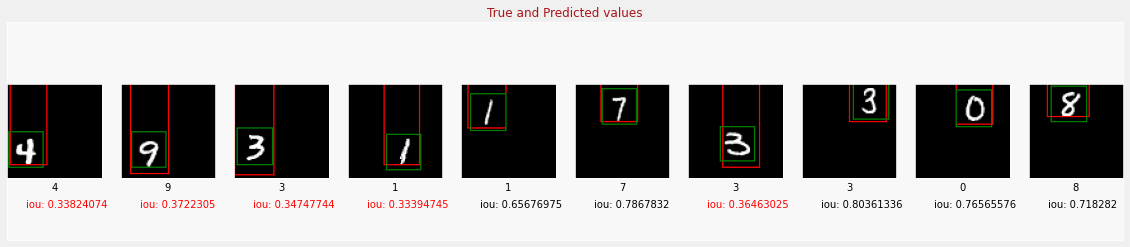

In [ ]:
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")

In [ ]:
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 6.0 MB/s 
     |████████████████████████████████| 40 kB 6.5 MB/s 
     |████████████████████████████████| 1.0 MB 66.2 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 5.8 MB 58.1 MB/s 
     |████████████████████████████████| 438 kB 39.3 MB/s 
     |████████████████████████████████| 511.7 MB 4.8 kB/s 
     |████████████████████████████████| 1.6 MB 53.4 MB/s 
     |████████████████████████████████| 5.8 MB 33.9 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempti

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

In [ ]:
predicted_bboxes

array([[0.2226851 , 0.        , 0.6029999 , 0.45039386],
       [0.3334157 , 0.        , 0.7449678 , 0.91138875],
       [0.06833965, 0.        , 0.5511426 , 0.5370703 ],
       ...,
       [0.12309048, 0.        , 0.48173442, 0.6895413 ],
       [0.        , 0.        , 0.32526538, 0.7425899 ],
       [0.2555172 , 0.        , 0.6414292 , 0.8326197 ]], dtype=float32)